In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import seaborn as sns
import joblib
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from matplotlib import pyplot
import matplotlib.pyplot as plt    

plt.style.use('ggplot')  
%matplotlib inline

In [2]:
raw_data = pd.read_csv('training_data/bband_training_data_long0518.csv')

In [3]:
# for long dataset out == 1 & side == 1 or -1
training_data = raw_data.copy()
training_data['out'] = training_data['out'].apply(lambda x:1 if x == 1 else 0)
training_data = training_data.sort_values(by=['date'])
training_data = training_data[training_data.side == 1]
# training_data = training_data[training_data.date > '2021-05-03']
print(f'training_data.shape : {training_data.shape}')

col_list = ['date', 'com_rev', 'd_yield', 'pb', 'AD', 'OBV', 'ADOSC', 'bias5',
    'bias10', 'bias20', 'bias60', 'acc5', 'acc10', 'acc20', 'acc60', 'rsi',
    'log_ret', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'volatility',
    'MA5', 'MA20', 'MA60', 'MACD', 'signal', 'hist',
    'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5',
    'log_t1', 'log_t2', 'log_t3', 'log_t4', 'log_t5', 'b_OBV', 'b_AD', 'b_ADOSC',
    'b_MA5', 'b_MA20', 'b_MA60', 'b_bias5', 'b_bias10', 'b_bias20', 'b_bias60',
    'b_acc5', 'b_acc10', 'b_acc20', 'b_acc60', 'b_volatility', 'long_ret', 'short_ret', 'out']

data = training_data[col_list]
train_data = data.iloc[:int(training_data.shape[0]*.7),:]
print(train_data.shape)
test_data = data.iloc[int(training_data.shape[0]*.7):,:]
print(test_data.shape)

training_data.shape : (12067, 59)
(8446, 57)
(3621, 57)


In [4]:
print(f'train_data.date.min {train_data.date.min()}')
print(f'train_data.date.max {train_data.date.max()}')
print(f'train_data.shape {train_data.shape}')
print(f'test_data.date.min {test_data.date.min()}')
print(f'test_data.date.max {test_data.date.max()}')
print(f'test_data.shape {test_data.shape}')

train_data.date.min 2016-12-27
train_data.date.max 2018-07-09
train_data.shape (8446, 57)
test_data.date.min 2018-07-09
test_data.date.max 2019-01-15
test_data.shape (3621, 57)


In [5]:
def Upsample(df):
    # Separate majority and minority classes
    shape_0 = df[df.out==0].shape[0]
    shape_1 = df[df.out==1].shape[0]
    if shape_0 > shape_1:
        df_majority = df[df.out==0]
        df_minority = df[df.out==1]
        n = 0
    else:
        df_majority = df[df.out==1]
        df_minority = df[df.out==0]
        n = 1
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=df.out.value_counts()[n],    # to match majority class
                                    random_state=123) # reproducible results
    
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    # Display new class counts
    print(f'before\n {df.out.value_counts()}')
    print(f'after\n {df_upsampled.out.value_counts()}')
    return df_upsampled

train_data_up = Upsample(train_data)
# test_data_up = Upsample(test_data)
# train_data_up = train_data_up.sample(frac=0.9, replace=True, random_state=1)

X = train_data_up.iloc[:,1:-3]
y = train_data_up.iloc[:,-1]
X_test = test_data.iloc[:,1:-3]
y_test = test_data.iloc[:,-1]

before
 0    5043
1    3403
Name: out, dtype: int64
after
 1    5043
0    5043
Name: out, dtype: int64


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7596
           1       0.37      1.00      0.54      4471

    accuracy                           0.37     12067
   macro avg       0.19      0.50      0.27     12067
weighted avg       0.14      0.37      0.20     12067

Confusion Matrix
[[   0 7596]
 [   0 4471]]

Accuracy
0.37051462666777163
long_ret
0.9574370749802862
AVG
0.0002644123377465579


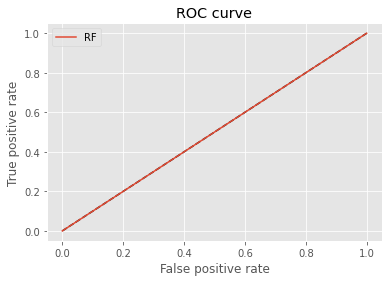

In [6]:
primary_data = raw_data.copy()
primary_data['out'] = primary_data['out'].apply(lambda x:1 if x == 1 else 0)
primary_data = primary_data.sort_values(by=['date'])
primary_data = primary_data[primary_data.side == 1]
primary_data['side'] = 1

p_pred = primary_data.side
p_test = primary_data.out
fpr_rf, tpr_rf, _ = roc_curve(p_test, p_pred)
print(classification_report(p_test, p_pred))
cf_matrix = confusion_matrix(p_test, p_pred)
print("Confusion Matrix")
print(cf_matrix)

print('')
print("Accuracy")
print(accuracy_score(p_test, p_pred))
print("long_ret")
print(sum(test_data['long_ret']))
print("AVG")
print(sum(test_data['long_ret'])/len(test_data['long_ret']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [7]:
# declare parameters
xgb_clf = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.05,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=10)

# fit the classifier to the training data
eval_set = [(X, y), (X_test, y_test)]
xgb_clf.fit(X, y, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      2553
           1       0.33      0.28      0.30      1068

    accuracy                           0.62      3621
   macro avg       0.52      0.52      0.52      3621
weighted avg       0.60      0.62      0.61      3621

Confusion Matrix
[[1939  614]
 [ 768  300]]

Accuracy
0.6183374758354045
long_ret
1.3061573452272492


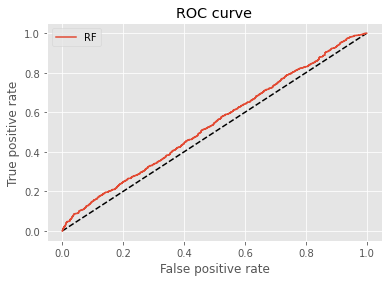

In [11]:
model = xgb_clf
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cf_matrix)

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

print("long_ret")
print(sum(y_pred_rf * test_data['long_ret'].to_numpy()))
# print("AVG")
# print(sum(y_pred_rf * test_data['long_ret'].to_numpy())/len(test_data['long_ret']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [12]:
a = test_data['long_ret'].to_numpy()
print('Oringinally')
print(f"total earning {sum(a)}")
print(f'trade {np.count_nonzero(a)} times')
print(f'{sum(a)/len(a)}')
print('')
for thres in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    # g = lambda x: x if x > thres else 0
    # vfunc = np.vectorize(g)
    # with_thres = vfunc(y_pred_rf)
    with_thres = []
    for item in y_pred_rf:
        if item > thres:
            with_thres.append(item)
        else:
            with_thres.append(0)
    a = with_thres * test_data['long_ret'].to_numpy()
    print(f'ML threshold :{thres}')
    print(f'trade {np.count_nonzero(with_thres)} times')
    print(f"total earning {sum(a)}")
    print('AVG')
    b = []
    for item in list(a):
        if item != 0:
            b.append(item)
    print(sum(a)/len(b))
    print('')

Oringinally
total earning 0.9574370749802862
trade 3621 times
0.0002644123377465579

ML threshold :0.2
trade 2916 times
total earning 1.2780956177419998
AVG
0.000438304395659122

ML threshold :0.3
trade 2155 times
total earning 1.1757676863840596
AVG
0.0005455998544705613

ML threshold :0.4
trade 1463 times
total earning 1.1135680368056948
AVG
0.0007611538187325324

ML threshold :0.5
trade 914 times
total earning 1.3605760027639993
AVG
0.0014885951890196928

ML threshold :0.6
trade 474 times
total earning 1.9809159855831637
AVG
0.0041791476489096285

ML threshold :0.7
trade 182 times
total earning 1.4618966320903641
AVG
0.008032399077419584

ML threshold :0.8
trade 46 times
total earning 0.6738734667282016
AVG
0.014649423189743513

ML threshold :0.9
trade 2 times
total earning 0.003774535609323584
AVG
0.001887267804661792



In [15]:
# joblib.dump(model,'lazypredict/XGBoost_mr_long_0419.pkl')

['lazypredict/XGBoost_mr_long_0419.pkl']

In [13]:
# retrieve performance metrics
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

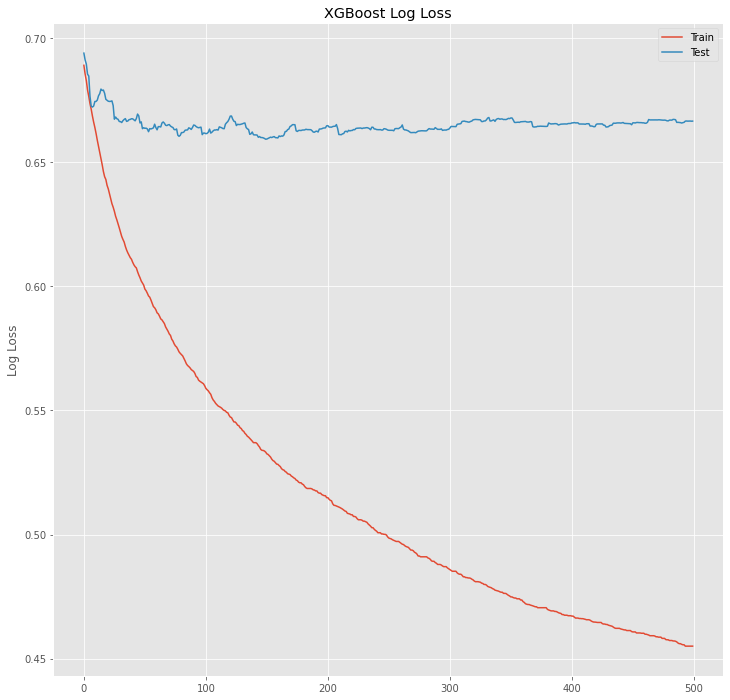

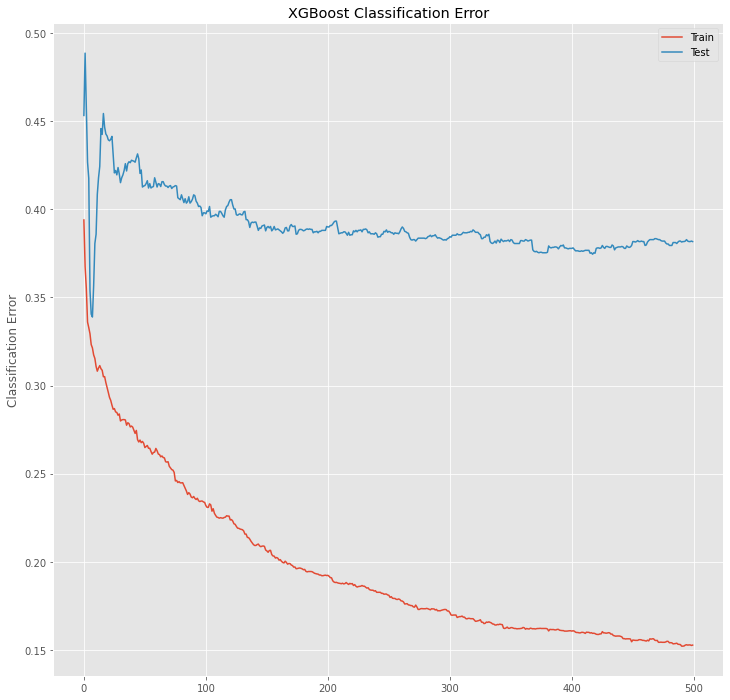

In [14]:
# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()

pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()


# plot classification error
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()

pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

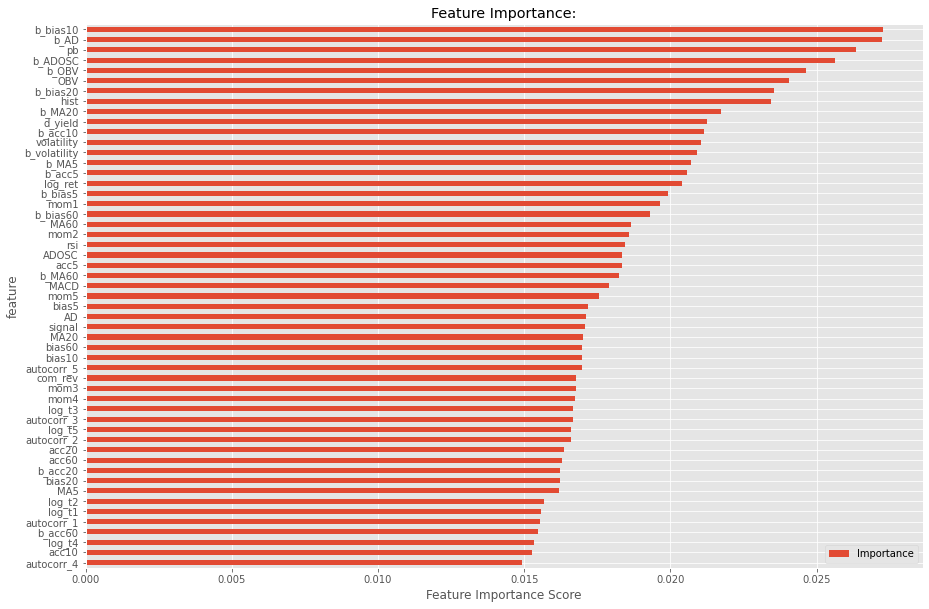

In [15]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 10)

feat_imp = pd.DataFrame({'Importance':model.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

In [49]:
model = joblib.load(r'C:\Users\Drey\finlab_ml_course\lazypredict\XGBoost_mr_long_0419.pkl')
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10,
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, n_estimators=1500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)

              precision    recall  f1-score   support

           0       0.62      0.84      0.71      5484
           1       0.36      0.15      0.21      3379

    accuracy                           0.58      8863
   macro avg       0.49      0.49      0.46      8863
weighted avg       0.52      0.58      0.52      8863

Confusion Matrix
[[4613  871]
 [2885  494]]

Accuracy
0.576215728308699


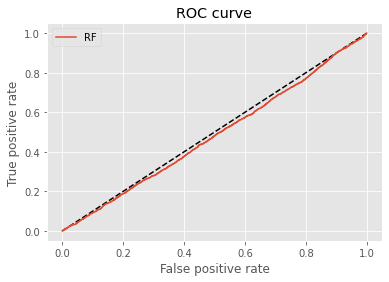

In [50]:
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [16]:
import shap

In [17]:
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(X_test)
shap.initjs()

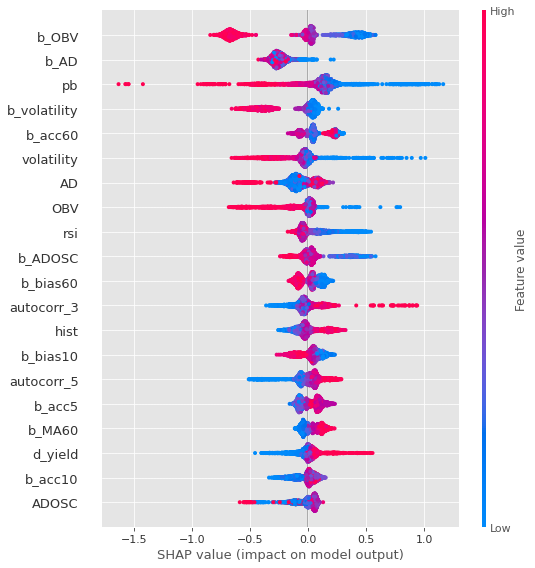

In [18]:
shap.summary_plot(shap_values, X_test)

In [19]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test.iloc[10,:])